# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import scikitplot as skplt
import pickle

from pathlib import Path
from matplotlib import pyplot as plt

from scipy import stats
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm

# 0.1. Helper Functions

In [2]:
def precision_at_k (data, target, score, k = 2000):
    
    # sort list by propensity score value
    data = data.sort_values(score, ascending = False)
    
    # create ranking order
    data['ranking'] = data.reset_index().index + 1 # ranking number starts at 1

    # create precision_at_k column
    data['precision_at_k'] = data[target].cumsum() / data['ranking']

    # return precision value at k row
    return data.loc[k, 'precision_at_k']


def recall_at_k (data, target, score, k = 2000):
    
    # sort list by propensity score value
    data = data.sort_values(score, ascending = False)
    
    # create ranking order
    data['ranking'] = data.reset_index().index + 1 # ranking number starts at 1

    # create recall_at_k column
    data['recall_at_k'] = data[target].cumsum() / data[target].sum() # target column must be binary (1 or 0 values)

    # return precision value at k row
    return data.loc[k, 'recall_at_k']

def save_model(path, filename, model):

    path_ = str(Path.cwd().parents[0])
    path_ = path_ + path + '/' + filename
    pickle.dump(model, open(path_, 'wb'))

    return None

# 1. Data Preparation

In [3]:
# load data
path = str(Path.cwd().parents[0] / "data" / "processed")
path = path + '/' + 'df_eda.csv'

df = pd.read_csv(path)

In [4]:
# return variables to original values

# response
# driving_license
# vehicle_damage
# previously_insured

for i in df.columns:

    if (i == 'response') | (i == 'driving_license') | (i == 'vehicle_damage') | (i == 'previously_insured'):
        df[i] = df[i].apply(lambda x: 1 if x == 'Yes' else 0)
    
    else:
        pass

In [5]:
df.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11,152,1,New,1,0,23367.0,249,0
1,13,Female,41,15,14,1,Average,0,1,31409.0,221,0
2,18,Female,25,35,152,1,New,0,1,46622.0,299,0
3,31,Female,26,8,160,1,New,0,0,2630.0,136,0
4,39,Male,45,8,124,1,Average,1,0,42297.0,264,0


In [6]:
# simulates production environment

X = df.drop('response', axis = 1) # real data does not contain response
y = df['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size = 0.20) # spit dataset between train and test

df = pd.concat([x_train, y_train], axis = 1)

# save validation datasets - they will be used to test the API later
save_model('/data/interim', 'x_val.pkl', x_val)
save_model('/data/interim', 'y_val.pkl', y_val)


## Standardization
Only attributes with Normal distribution.

In [24]:
# annual_premium (we will not remove outliers now)

ss = pp.StandardScaler()

df['annual_premium'] = ss.fit_transform(df[['annual_premium']].values) # encoder receives an array

## Rescaling

In [25]:
# saves scaler to the same variable which will be used in the test
mms_age = pp.MinMaxScaler() 
mms_vintage = pp.MinMaxScaler()

# age
df['age'] = mms_age.fit_transform(df[['age']].values)

# vintage
df['vintage'] = mms_vintage.fit_transform(df[['vintage']].values)

## Encoding
Only categorical attributes which we want to mantain its nature (eg. binary, ordinal)

In [26]:
# gender
target_encode_gender = df.groupby('gender')['response'].mean()
df.loc[:,'gender'] = df['gender'].map(target_encode_gender)

# region_code - Frequency Encoding | Target Encoding (we choose this) | Weigthed Target Encoding
target_encode_region_code = df.groupby('region_code')['response'].mean()
df.loc[:,'region_code'] = df['region_code'].map(target_encode_region_code) # replace all values within policy_sales_channel column with encoded values

# vehicle_age - One Hot Encoding (we choose this) | Order Encoding
df = pd.get_dummies(df, prefix = 'vehicle_age', columns = ['vehicle_age'])

# policy_sales_channel - Target Encoding | Frequency Encoding (we choose this)
# Frequency Encoding gives more weight to more frequent values of the categorical attribute
fe_policy_sales_channel = df.groupby('policy_sales_channel').size() / len(df)
df.loc[:,'policy_sales_channel'] = df['policy_sales_channel'].map(fe_policy_sales_channel) # replace all values within policy_sales_channel column with encoded values


# Saving Encoders

In [27]:
# saving encoders
folder = '/src/features'

filename = {
    'annual_premium_scaler.pkl':ss,
    'age_scaler.pkl':mms_age,
    'vintage_scaler.pkl':mms_vintage,
    'target_encoder_gender_scaler.pkl':target_encode_gender,
    'target_encoder_region_code_scaler.pkl':target_encode_region_code,
    'frequency_encoder_policy_sales_scaler.pkl':fe_policy_sales_channel
    }


for filename, scaler in filename.items():
    save_model(folder, filename, scaler)

## Validation Preparation

In [10]:
# applies same training encoders to testing (validation, val) data

# gender
x_val.loc[:, 'gender'] = x_val.loc[:, 'gender'].map(target_encode_gender)

# age
x_val.loc[:, 'age'] = mms_age.transform(x_val[['age']].values)

# region_code
x_val.loc[:, 'region_code'] = x_val.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age
x_val.loc[:, 'vehicle_age'] = pd.get_dummies(x_val, prefix = 'vehicle_age', columns = ['vehicle_age'])

# annual_premium
x_val.loc[:, 'annual_premium'] = ss.transform(x_val[['annual_premium']].values)

# policy_sales_channel
x_val.loc[:, 'policy_sales_channel'] = x_val['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_val.loc[:, 'vintage'] = mms_vintage.transform(x_val[['vintage']].values)

# fillna
x_val = x_val.fillna(0)

# 2. Feature Selection

## 2.1. Features Importance

In [11]:
# # model definition
# forest = en.ExtraTreesClassifier(n_estimators = 250, random_state = 0, n_jobs = -2) # n_jobs will not use all cores

# # data preparation
# x_train_n = df.drop(['id', 'response'], axis = 1)
# y_train_n = y_train.values
# forest.fit(x_train_n, y_train_n)

In [12]:
# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
# indices = np.argsort(importances)[::-1]

# # Print feature ranking
# print('Feature Ranking:')
# data = pd.DataFrame()
# for i, j in zip(x_train_n, forest.feature_importances_):
#     aux = pd.DataFrame({'feature': i, 'importance': j}, index = [0])
#     data = pd.concat([data, aux], axis = 0)

# print(data.sort_values('importance', ascending = False))

# # Plot the impurity-based feature importances of the forest
# plt.figure()
# plt.title('Feature Importances')
# plt.bar(range(x_train_n.shape[1]), importances[indices], color = 'r', yerr = std[indices], align = 'center')
# plt.xticks(range(x_train_n.shape[1]), indices)
# plt.xlim([-1, x_train_n.shape[1]])
# plt.show()


# 3. Machine Learning

In [13]:
# arbitrary selection
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

In [14]:
# using only the selected features to train and test (validation) the model
x_train = df[cols_selected]
x_val = x_val[cols_selected]

## 3.1. KNN

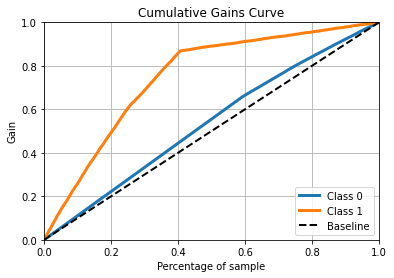

In [15]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors = 7)

# model training
knn_model.fit(x_train, y_train)

# model prediction - Generalizing Power
yhat_knn = knn_model.predict_proba(x_val)

# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

# what this chart tell?
# if i make the offer to 40% of the ordered list, i will find ~85% of interested people (with 07 neighbors)
# this means the KNN model left interested people on the end of the list
# more KNN Neighbors = i will find more interested people

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

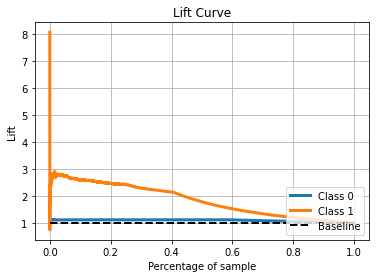

In [16]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_knn)

## 3.2. Linear Regression

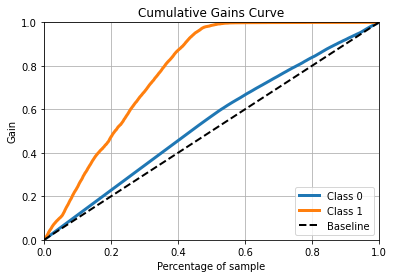

In [17]:
# model definition
lr_model = lm.LogisticRegression(random_state = 42)

# model training
lr_model.fit(x_train, y_train)

# model prediction - Generalizing Power
yhat_lr = lr_model.predict_proba(x_val)

# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

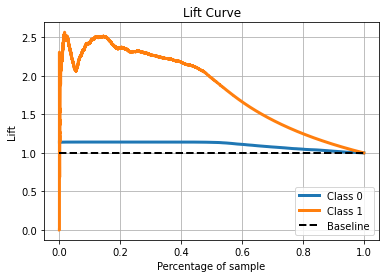

In [18]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_lr)

In [19]:
# HOMEWORK: test with random forest and xgboost and compares cumulative gains curves.
# you want to find 100% of interested people with least percentage of sample.
# Test with PCA Encoding.

# HOMEWORK: find a Ranking Metric to summarize Cumulative Gains Curve chart.

## 3.3. Extra Trees

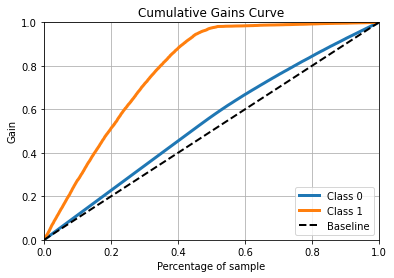

In [20]:
# model definition
et = en.ExtraTreesClassifier(n_estimators = 100, n_jobs = -2, random_state = 42)

# model training
et.fit(x_train, y_train)

# model prediction - Generalizing Power
yhat_et = et.predict_proba(x_val)

skplt.metrics.plot_cumulative_gain(y_val, yhat_et);

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

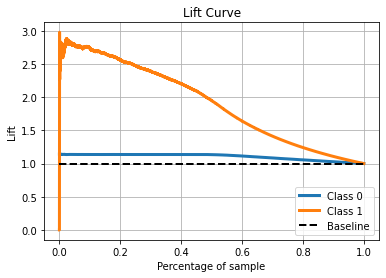

In [21]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_et)

## 3.4. Random Forest

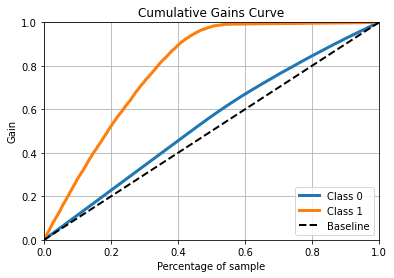

In [22]:
# model definition
rf = en.RandomForestClassifier(n_estimators = 100, n_jobs = -2, random_state = 42)

# model training
rf.fit(x_train, y_train)

# model prediction - Generalizing Power
yhat_rf = rf.predict_proba(x_val)

# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf);

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

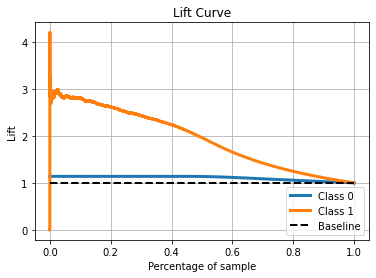

In [23]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_rf)

# 4. Model Performance

In [24]:
# copy data
df_perf = x_val.copy()
df_perf['response'] = y_val.copy()
df_perf.reset_index(inplace = True) # creates a new index because old index was clients ID.
df_perf.rename(columns = {'index':'id'}, inplace = True)

# propensity score - from KNN Model
df_perf['score_knn'] = yhat_knn[:,1].tolist() # get all propensity score values of response = 1 then converts to list

# propensity score - from Linear Regression Model
df_perf['score_lr'] = yhat_lr[:,1].tolist() # get all propensity score values of response = 1 then converts to list

# propensity score - from Extra Trees Model
df_perf['score_et'] = yhat_et[:,1].tolist() # get all propensity score values of response = 1 then converts to list

# propensity score - from Random Forest Model
df_perf['score_rf'] = yhat_rf[:,1].tolist() # get all propensity score values of response = 1 then converts to list

k = 50
scores = ['score_knn', 'score_lr', 'score_et', 'score_rf']

# create lists to store performance metrics
performance = []
aux = []

for i in scores:
    # compute Precision at k (Precision Top K) = ratio of True Positives within all Positives?
    precision = precision_at_k(df_perf, 'response', i, k)

    # compute Recall at k = ratio of True Positives within all instances of the dataset
    recall = recall_at_k(df_perf, 'response', i, k)

    # save performance metrics
    aux = [i, precision, recall, k]
    performance.append(aux)

# convert performance metrics list to dataframe
df_perf = pd.DataFrame(performance, columns = ['model', 'precision', 'recall', 'k'])
df_perf = df_perf.round(decimals = 4).sort_values('recall', ascending = False)
df_perf

,model,precision,recall,k
0,score_knn,0.2692,0.8241,50
1,score_lr,0.2803,0.7015,50
2,score_et,0.3268,0.3976,50
3,score_rf,0.3480,0.2793,50


# 5.0 Saving Models

#

In [51]:
folder = '/src/models'

models_names = {
    'model_knn.pkl':knn_model, 
    'model_linear_regression.pkl':lr_model, 
    'model_extra_trees.pkl':et,
    'model_random_forest.pkl':rf
    }

for filename, model in models_names.items():
    save_model(folder, filename, model)